In [13]:
import re
import pickle
import numpy as np
import preprocess
import random
import thulac
import pypinyin
from gensim.models import word2vec
import logging

In [7]:
def load_raw_data():
    """Return titles and lyrics."""
    
    titles_lyrics = preprocess.load_from_pickle()
    if titles_lyrics == None:
        preprocess.preprocess()
        titles_lyrics = preprocess.load_from_pickle()
    return titles_lyrics

In [3]:
def lyrics_without_timing():
    """Return a list of lyrics, pure text, no timing"""
    _, lyrics = load_raw_data()
#     del_timing = lambda s: re.sub('\[.*\]', '', s).strip()
#     lyrics = [[del_timing(sentence) for sentence in lyric if del_timing(sentence) != '']\
#              for lyric in lyrics]
    
    del_not_chinese = lambda s: re.sub(u'[^\u4E00-\u9FA5 ]', '', s).strip()
    lyrics = [[del_not_chinese(sentence) for sentence in lyric\
               if del_not_chinese(sentence) != ''] for lyric in lyrics]
    
    lyrics = [[sentence for sentence in lyric
               if len(sentence) > 6
               and '词曲' not in sentence and '作曲' not in sentence and
               '编曲' not in sentence and '作词' not in sentence
              ]for lyric in lyrics]

    lyrics = [lyric[3:-1] for lyric in lyrics if len(lyric) > 15]
    return lyrics

In [9]:
def cut_and_save(lyrics):
    cut = thulac.thulac(seg_only=True)  #只进行分词，不进行词性标注
    with open('all_lyrics.txt', 'wb') as f:
        print(len(lyrics))
        for i, lyric in enumerate(lyrics):
            if (i % 1000 == 0):
                print(i)
            for sentence in lyric:
                f.write((' '.join(list(zip(*cut.cut(sentence)))[0])).encode('utf8'))

In [8]:
def train_word2vec():
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    sentences = word2vec.Text8Corpus("all_lyrics.txt")  # 加载语料
    model = word2vec.Word2Vec(sentences, size=512)  # 训练skip-gram模型; 默认window=5
    model.save('word2vec_model')

In [116]:
def count_rhythm(lyrics):
    rhythm_dict = {}
    for lyric in lyrics:
        rhythm = [pypinyin.pinyin(sentence, style=pypinyin.Style.FINALS)[-1][0]\
                  for sentence in lyric]

        for i in range(2, len(lyric)):
            rhythm_dict[(rhythm[i], rhythm[i - 1])] = \
            rhythm_dict.setdefault((rhythm[i], rhythm[i - 1]), 0) + 1
            
            rhythm_dict[(rhythm[i], rhythm[i - 2])] = \
            rhythm_dict.setdefault((rhythm[i], rhythm[i - 2]), 0) + 1

    return rhythm_dict

In [117]:
rhythm_joint_distribution = count_rhythm(lyrics)

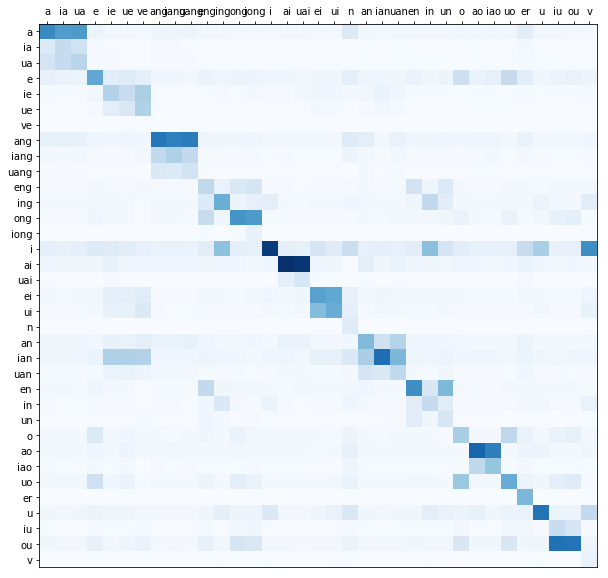

In [120]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.rcParams['figure.figsize'] = (10,10)

pinyin_x = np.unique([key[0][::-1] for key in rhythm_joint_distribution.keys()])
pinyin_x = pinyin_x[pinyin_x != '']
pinyin_y = np.unique([key[1][::-1] for key in rhythm_joint_distribution.keys()])
pinyin_y = pinyin_y[pinyin_y != '']

mat = np.zeros([len(pinyin_x), len(pinyin_y)], dtype='float')
for i in range(len(pinyin_x)):
    for j in range(len(pinyin_y)):
        mat[i][j] = rhythm_joint_distribution.get((pinyin_x[i][::-1], pinyin_y[j][::-1]), 0)

mat = mat / np.sum(mat, axis=1)

fig, ax = plt.subplots()
heatmap = ax.pcolor(mat, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(mat.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(mat.shape[0]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels([pinyin[::-1] for pinyin in pinyin_y], minor=False)
ax.set_yticklabels([pinyin[::-1] for pinyin in pinyin_x], minor=False)
plt.show()

In [119]:
finals_joint_distribution = rhythm_joint_distributionthm_joint_distributionythm_joint_distribution

In [115]:
# with_initials = rhythm_joint_distribution

In [14]:
if __name__ == '__main__':
#     lyrics = lyrics_without_timing()
#     cut_and_save(lyrics)
    train_word2vec()

2017-10-25 19:58:06,363 : INFO : collecting all words and their counts
2017-10-25 19:58:06,367 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-10-25 19:58:10,112 : INFO : collected 848224 word types from a corpus of 12314495 raw words and 1232 sentences
2017-10-25 19:58:10,113 : INFO : Loading a fresh vocabulary
2017-10-25 19:58:10,672 : INFO : min_count=5 retains 107487 unique words (12% of original 848224, drops 740737)
2017-10-25 19:58:10,673 : INFO : min_count=5 leaves 11091384 word corpus (90% of original 12314495, drops 1223111)
2017-10-25 19:58:10,897 : INFO : deleting the raw counts dictionary of 848224 items
2017-10-25 19:58:10,923 : INFO : sample=0.001 downsamples 50 most-common words
2017-10-25 19:58:10,924 : INFO : downsampling leaves estimated 8224217 word corpus (74.1% of prior 11091384)
2017-10-25 19:58:10,924 : INFO : estimated required memory for 107487 words and 512 dimensions: 494010252 bytes
2017-10-25 19:58:11,228 : INFO : resetting 

2017-10-25 19:59:24,378 : INFO : PROGRESS: at 36.06% examples, 206525 words/s, in_qsize 5, out_qsize 0
2017-10-25 19:59:25,379 : INFO : PROGRESS: at 36.56% examples, 206564 words/s, in_qsize 5, out_qsize 0
2017-10-25 19:59:26,384 : INFO : PROGRESS: at 37.05% examples, 206540 words/s, in_qsize 5, out_qsize 0
2017-10-25 19:59:27,392 : INFO : PROGRESS: at 37.56% examples, 206652 words/s, in_qsize 5, out_qsize 0
2017-10-25 19:59:28,423 : INFO : PROGRESS: at 38.07% examples, 206581 words/s, in_qsize 5, out_qsize 0
2017-10-25 19:59:29,499 : INFO : PROGRESS: at 38.60% examples, 206577 words/s, in_qsize 5, out_qsize 0
2017-10-25 19:59:30,509 : INFO : PROGRESS: at 39.12% examples, 206670 words/s, in_qsize 5, out_qsize 0
2017-10-25 19:59:31,529 : INFO : PROGRESS: at 39.63% examples, 206643 words/s, in_qsize 5, out_qsize 0
2017-10-25 19:59:32,583 : INFO : PROGRESS: at 40.16% examples, 206634 words/s, in_qsize 5, out_qsize 0
2017-10-25 19:59:33,628 : INFO : PROGRESS: at 40.70% examples, 206691 wor

2017-10-25 20:00:46,581 : INFO : PROGRESS: at 77.82% examples, 207879 words/s, in_qsize 5, out_qsize 0
2017-10-25 20:00:47,640 : INFO : PROGRESS: at 78.36% examples, 207885 words/s, in_qsize 5, out_qsize 0
2017-10-25 20:00:48,645 : INFO : PROGRESS: at 78.86% examples, 207893 words/s, in_qsize 5, out_qsize 0
2017-10-25 20:00:49,689 : INFO : PROGRESS: at 79.40% examples, 207929 words/s, in_qsize 5, out_qsize 0
2017-10-25 20:00:50,689 : INFO : PROGRESS: at 79.90% examples, 207923 words/s, in_qsize 5, out_qsize 0
2017-10-25 20:00:51,699 : INFO : PROGRESS: at 80.44% examples, 207976 words/s, in_qsize 5, out_qsize 0
2017-10-25 20:00:52,719 : INFO : PROGRESS: at 80.97% examples, 208027 words/s, in_qsize 5, out_qsize 0
2017-10-25 20:00:53,773 : INFO : PROGRESS: at 81.51% examples, 208025 words/s, in_qsize 5, out_qsize 0
2017-10-25 20:00:54,785 : INFO : PROGRESS: at 82.03% examples, 208049 words/s, in_qsize 5, out_qsize 0
2017-10-25 20:00:55,845 : INFO : PROGRESS: at 82.56% examples, 208044 wor